# BA, 1024²

| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/05/2024          |
| Updated |  01/08/2025          |

In [3]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
reses = [512, 1024]
res = reses[-1]
n_p = 'np1'
runs = {
    f'dust_particles/{n_p}': {
        'ls': 'dotted',
        'codes' : {
            'Athena':       'tab:green',
            'Athena++':     'tab:red',
        }
    },
    'dust_fluid': {
        'ls': 'solid',
        'codes' : {
            'Athena++':     'tab:purple',
            'FARGO3D':      'tab:olive',
            'Idefix':       'tab:orange',
            'LA-COMPASS':   'tab:cyan'
        }
    }
}

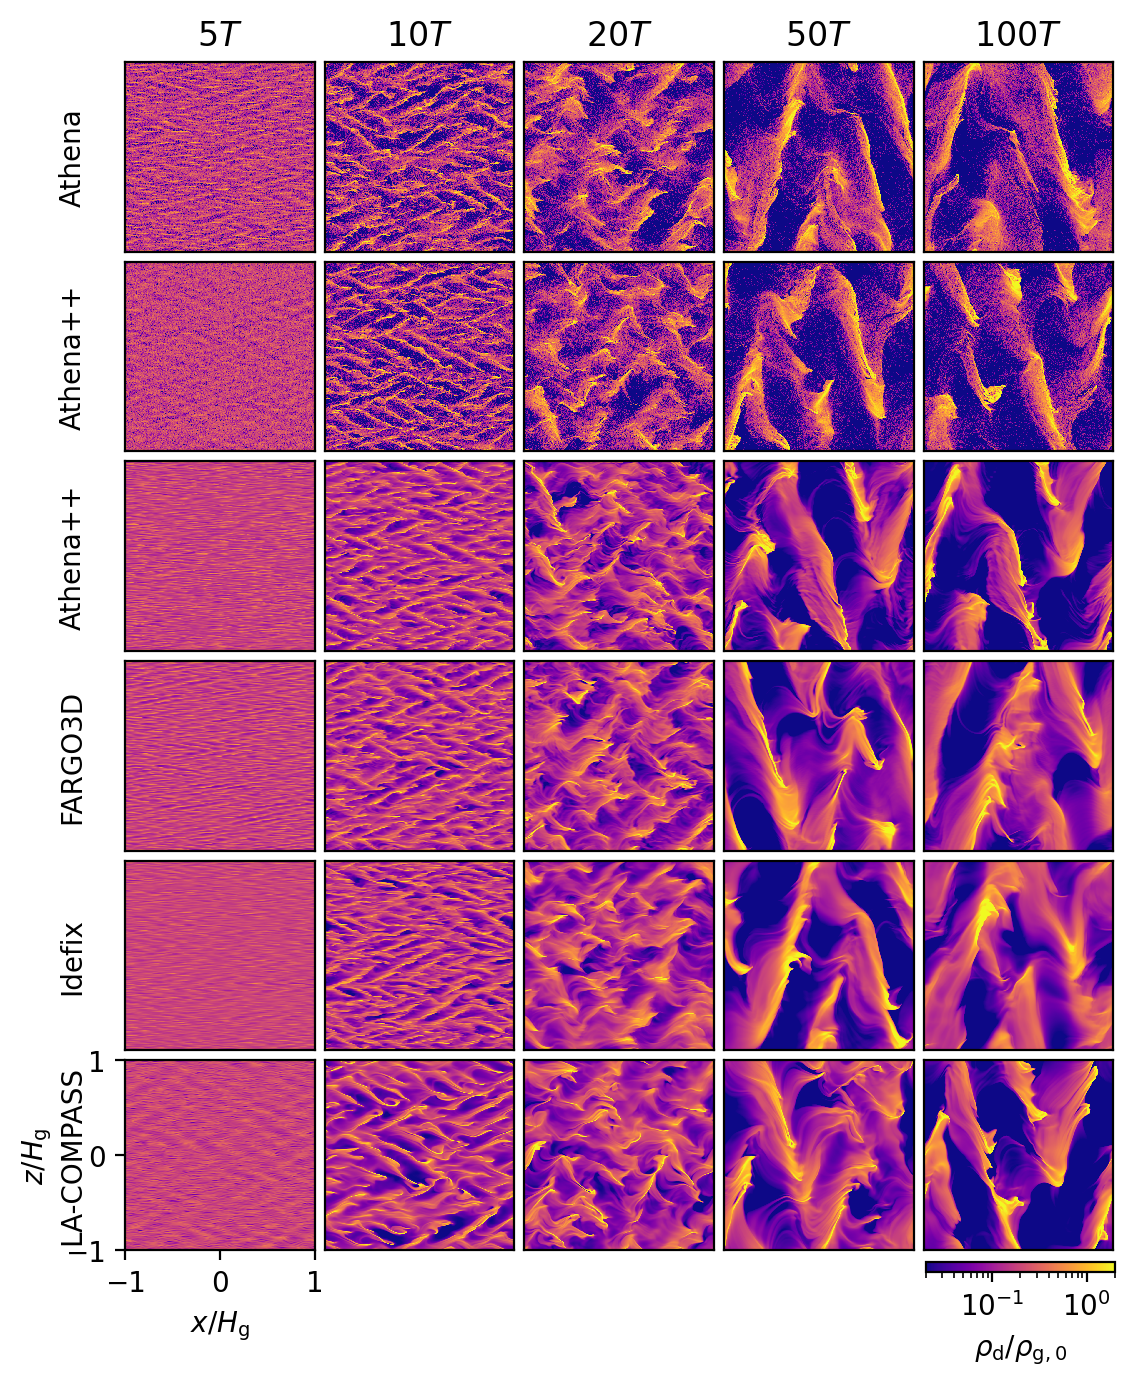

In [6]:
#===============================================================================
times = [5, 10, 20, 50, 100]
vmin, vmax = 2e-2, 2e0 # BA CPDD > 85%; CPDD < 5%
nrows = 0
for key, value in runs.items():
    for code in value['codes']:
        nrows += 1

# Plot
fig = plt.figure(figsize=(8, 9*nrows/7), dpi=200)
ax_grid = AxesGrid(fig, 111, nrows_ncols=(nrows, len(times)), axes_pad=0.05,
                   share_all=True, label_mode='1')
j = 0
for key, value in runs.items():
    for code in value['codes']:
        path = f'{root}/{model}/{problem}/{res}/{key}/{code}'
        row = j*len(times)
        for i, time in enumerate(times):
            if j == 0:
                ax_grid[i].set_title(rf'{time}$T$')
            if i == 0:
                ax_grid[row].text(-0.35, 0.5, f'{code}', va='center',
                                rotation='vertical',
                                transform=ax_grid[row].transAxes)
            snapshot = np.load(f'{path}/{time}.npz')
            x = snapshot['x']
            z = snapshot['z']
            rhop = snapshot['rhop']
            clip = np.clip(rhop, vmin, vmax)
            pcm = ax_grid[row+i].pcolormesh(x, z, clip, cmap='plasma',
                                            rasterized=True,
                                            norm=colors.LogNorm(vmin=vmin,
                                                                vmax=vmax))
            ax_grid[row+i].tick_params(bottom=False, left=False)
        j += 1

# Format plots
x1 = ax_grid[-1].get_position().x1 - 0.018
bot_left = len(ax_grid)-len(times)
plt.colorbar(pcm, orientation='horizontal', shrink=0.153, anchor=(x1, -0.13),
             label=r'$\rho_\mathrm{d}/\rho_\mathrm{g,0}$')
ax_grid[bot_left].set(xlabel=r'$x/H_\mathrm{g}$', ylabel=r'$z/H_\mathrm{g}$')
ax_grid[bot_left].xaxis.set_ticks([-1, 0, 1])
ax_grid[bot_left].yaxis.set_ticks([-1, 0, 1])
ax_grid[bot_left].tick_params(bottom=True, left=True)
plt.savefig(f'{problem}-{res}_snapshots.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

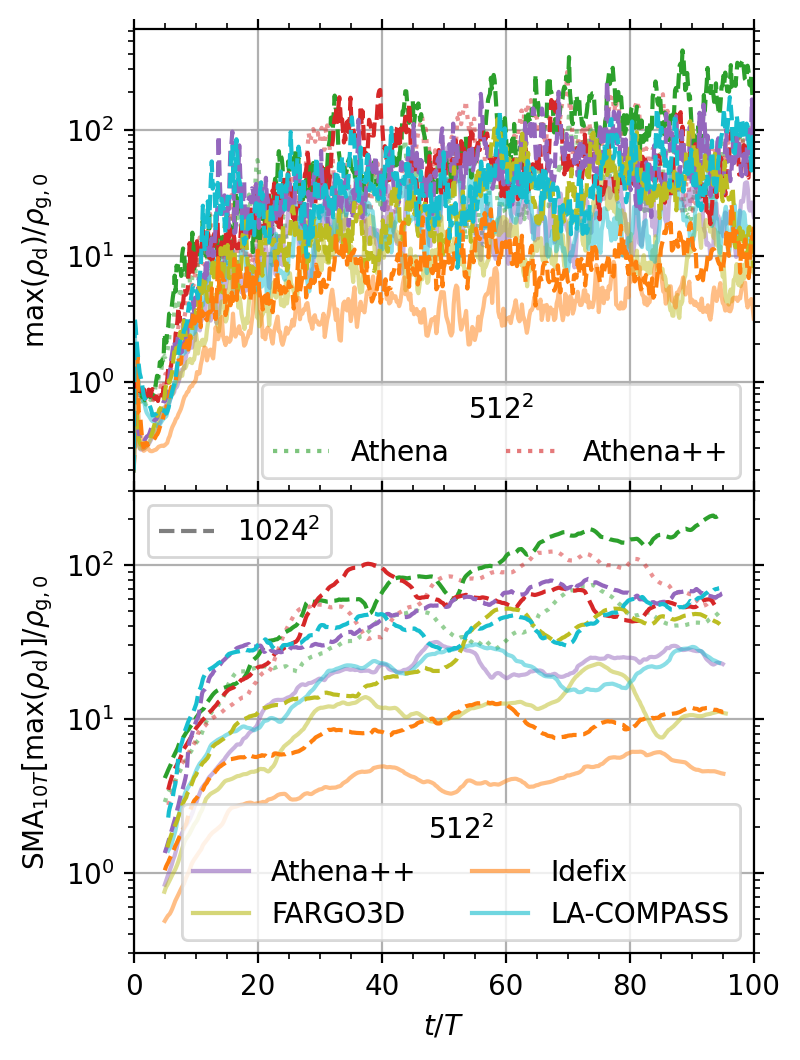

In [10]:
#===============================================================================
def print_samples(res, code, t, step, dt, window):
    """Print the number of samples in the time series."""
    print(f'{res}² {code} samples\n=======================')
    print(f'\t  Total: {len(t)}')
    print(f'\tStrided: {len(t[::step])}')
    print(f'\tPer {dt}T: {window}')

diag = False
dt = 10  # [T]

# Lowest cadence
path = f'{root}/{model}/{problem}/1024/dust_fluid/FARGO3D'
n_min = len(np.load(f'{path}/time_series.npz')['t'])

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=200)
c_handles, ls_handles = [[], []], []
for res in reses:
    for k, (key, value) in enumerate(runs.items()):
        for code, color in value['codes'].items():
            path = f'{root}/{model}/{problem}/{res}/{key}/{code}'
            data = np.load(f'{path}/time_series.npz')
            t = data['t']
            if res == 512:
                alpha = 0.5
                ls = value['ls']
                c_handles[k].append(axs[k].plot([],[], alpha=alpha, c=color,
                                    label=code, ls=ls)[0])
            else:
                alpha = 1.0
                ls = 'dashed'
            # Strided
            step = len(t)//n_min
            if step < 2:
                step = 1 if len(t)%n_min/n_min < 0.5 else 2
            axs[0].plot(t[::step], data['maxrhop'][::step], alpha=alpha,c=color,
                        ls=ls)
            # SMA
            window = len(t)//int(t[-1]/dt)
            print_samples(res, code, t, step, dt, window) if diag else None
            df = pd.DataFrame(data=data['maxrhop'], index=t)
            df['sma'] = df.rolling(window, center=True).mean()
            axs[1].plot(df['sma'], alpha=alpha, c=color, ls=ls)

# Custom legends
ls_handles.append(axs[0].plot([], [], c='tab:gray', ls='dashed',
                  label=r'$1024^2$')[0])
axs[1].add_artist(axs[1].legend(handles=ls_handles, loc='upper left'))

# Format plots
for k, ax in enumerate(axs):
    ax.add_artist(ax.legend(framealpha=0.56, handles=c_handles[k],
                            loc='lower right', ncol=2, title=r'$512^2$'))
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0].set(ylabel=rf'$\max(\rho_\mathrm{{d}})/\rho_\mathrm{{g,0}}$')
axs[1].set(xlabel=r'$t/T$', xlim=(0, 100), ylim=(3e-1, 3e2),
           ylabel=rf'$\mathrm{{SMA}}_{{{dt}T}}[\max(\rho_\mathrm{{d}})]$'\
                  +r'$/\rho_\mathrm{{g,0}}$')
fig.subplots_adjust(hspace=0)
plt.savefig(f'{problem}-{res}_time_series.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'{problem}-{res}_time_series.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

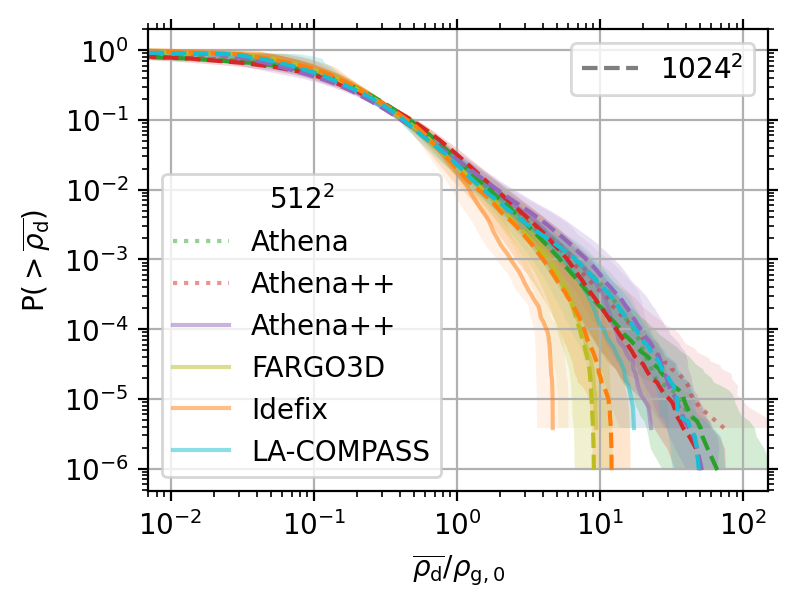

In [11]:
#===============================================================================
times = [20, 50, 100]  # [T]

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
c_handles, ls_handles = [], []
for res in reses:
    indices = -np.unique(np.logspace(np.log2(res**2), 0, num=100, base=2,
                         dtype=int))
    for key, value in runs.items():
        for code, color in value['codes'].items():
            path = f'{root}/{model}/{problem}/{res}/{key}/{code}'
            rhops = []
            for i, time in enumerate(times):
                snapshot = np.load(f'{path}/{time}.npz')
                sort = np.sort(snapshot['rhop'], axis=None)
                rhops.append(sort)
            rhops = np.asarray(rhops)
            avgs = np.average(rhops, axis=0)
            cdf = np.linspace(1, 0, avgs.size, endpoint=False)
            log = np.log(np.clip(rhops, 1e-45, None))
            std_log = np.std(log, axis=0)
            stds = np.clip(np.exp(std_log), None, 3)
            cdf = np.take_along_axis(cdf, indices, 0)
            avgs = np.take_along_axis(avgs, indices, 0)
            stds = np.take_along_axis(stds, indices, 0)
            if res == 512:
                alpha = 0.5
                ls = value['ls']
                hatch = None
                c_handles.append(ax.plot([],[], alpha=alpha, c=color,
                                 label=code, ls=ls)[0])
            else:
                alpha = 1.0
                ls = 'dashed'
            ax.plot(avgs, cdf, alpha=alpha, c=color, ls=ls)
            ax.fill_betweenx(cdf, avgs/stds, avgs*stds, alpha=alpha/5,
                             color=color, ec=None)

# Custom legends
ax.add_artist(ax.legend(handles=c_handles, loc='lower left', title=r'$512^2$'))
ls_handles.append(ax.plot([], [], c='tab:gray', ls='dashed',
                  label=r'$1024^2$')[0])
ax.add_artist(ax.legend(framealpha=0.56, handles=ls_handles, loc='upper right'))

# Format plots
ax.grid()
ax.minorticks_on()
ax.set(xlim=(7e-3, 1.5e2), xscale='log', yscale='log', 
       xlabel=r'$\overline{\rho_\mathrm{d}}/\rho_\mathrm{g,0}$',
       ylabel=r'P$(>\overline{\rho_\mathrm{d}})$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig(f'{problem}-{res}_CDF.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'{problem}-{res}_CDF.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

## Data compliance

### Athena++

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena++'
prefix = 'data_coordinates_dust_rho_'
suffix = '_orbits.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [5, 10, 20, 50, 100]

# Inspect
np.load(f'{path}/old/{prefix}{times[1]:03}{suffix}', mmap_mode='r').files

# Standardize
for time in times:
    snapshot = np.load(f'{path}/old/{prefix}{time:03}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=snapshot['x_coord'], z=snapshot['z_coord'],
                        rhop=snapshot['rho_d'])

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena++'
fname = 'data_time_dust_ratio_series.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
# np.load(f'{path}/old/{fname}', mmap_mode='r').files
# np.shape(snapshot['rhop'])

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['time']/2/np.pi,
                    maxrhop=time_series['RatioMax'])


### FARGO3D

In [5]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'{res}/dust_{dust}/{n_p}'
code = 'FARGO3D'
prefix = 'dust1dens'
suffix = '.dat'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [5, 10, 20, 50, 100]

# Load separate grid
snapshot = np.load(f'{path}/old/0.npz', mmap_mode='r')
x = snapshot['x']
z = snapshot['z']

# Inspect
# np.fromfile(f'{path}/old/{prefix}{times[0]}{suffix}').reshape(1024,1024)

# # Standardize
for time in times:
    rhop = np.fromfile(f'{path}/old/{prefix}{time}{suffix}').reshape(1024,1024)
    np.savez_compressed(f'{path}/{time}', x=x, z=z, rhop=rhop)

In [9]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'{res}/dust_{dust}/{n_p}'
code = 'FARGO3D'
# fname = 'data_time_dust_ratio_series.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
time_series = np.load(f'{path}/old/time_series1024.npz', mmap_mode='r')

# Standardize
inverse_omega = time_series['arr_0']
maxrhop = time_series['arr_1']
np.savez_compressed(f'{path}/time_series', t=inverse_omega/2/np.pi,
                    maxrhop=maxrhop)


### Idefix

In [6]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'{res}/dust_{dust}/{n_p}'
code = 'Idefix'
prefix = 'dust_'
suffix = '.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [0, 5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid.npz', mmap_mode='r')#.files
x = grid['x']
z = grid['z']

# Inspect
np.load(f'{path}/old/{prefix}{times[0]}{suffix}', mmap_mode='r').files
np.load(f'{path}/old/gas_{times[0]}{suffix}', mmap_mode='r').files
# np.shape(snap['arr_0'])

# # Exception
# time = 628
# snap = np.load(f'{path}/old/{prefix}{time}.npy')
# time = 100
# np.savez_compressed(f'{path}/{time}', x=x, z=z,
#                     rhop=snap)#.transpose())

# # Standardize
for i, time in enumerate(times):
    gas = np.load(f'{path}/old/gas_{time}{suffix}')
    dust = np.load(f'{path}/old/{prefix}{time}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        ux=gas['vx_gas'].transpose(),
                        uz=gas['vz_gas'].transpose(),
                        vx=dust['vx_dust'].transpose(),
                        vz=dust['vz_dust'].transpose(),
                        rhog=gas['rho_gas'].transpose(),
                        rhop=dust['rho_dust'].transpose())

In [7]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'{res}/dust_{dust}/{n_p}'
code = 'Idefix'
fname = 'time_series.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['time'],
                    maxrhop=time_series['rho_max'])


### LA-COMPASS

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'LA-COMPASS'
prefix = 'rhod_'
suffix = 'p_1024x1024_BA.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
# np.load(f'{path}/old/{prefix}{times[0]}{suffix}', mmap_mode='r').files
# np.shape(snapshot['rhop'])

# Standardize
for time in times:
    snapshot = np.load(f'{path}/old/{prefix}{time}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhop=snapshot['rho_d'])

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'LA-COMPASS'
fname = 'hst_1024x1024_BA.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
# np.load(f'{path}/old/{fname}', mmap_mode='r').files
len(np.load(f'{path}/old/{fname}', mmap_mode='r')['max_rhod'])

# Reconstruct times from inspection
maxrhop = np.load(f'{path}/old/{fname}', mmap_mode='r')['max_rhod']
t = np.linspace(0, 2*len(maxrhop)/100, len(maxrhop))

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=t/2/np.pi,
                    maxrhop=time_series['max_rhod'])

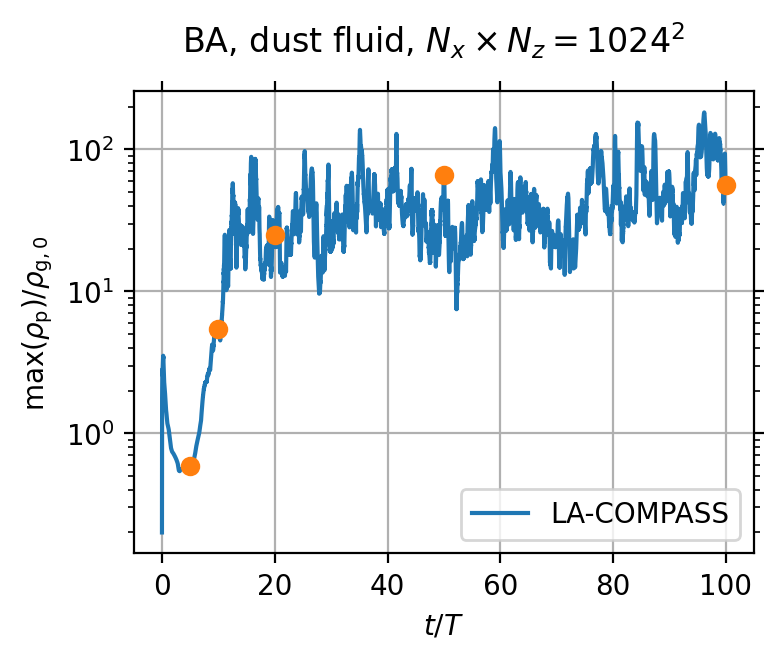

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'fluid'
n_p = ''
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
codes = ['LA-COMPASS']
prefix = 'rhod_'
suffix = 'p_1024x1024_BA.npz'
times = [5, 10, 20, 50, 100]

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
if dust == 'particles':
    fig.suptitle(rf'{problem}, $n_\mathrm{{p}} = {n_p[2:]}, N_x \times N_z = {res}^2$',
                 y=1)
elif dust == 'fluid':
    fig.suptitle(rf'{problem}, dust fluid, $N_x \times N_z = {res}^2$',
                 y=1)

for j, code in enumerate(codes):
    path = f'{root}/{model}/{problem}/{variation}/{code}'
    time_series = np.load(f'{path}/time_series.npz')
    ax.plot(time_series['t'], time_series['maxrhop'], label=code)

for time in times:
    snap = np.load(f'{path}/old/{prefix}{time}{suffix}')
    ax.plot(snap['time']/2/np.pi, np.max(snap['rho_d']), marker='o',
            color='tab:orange')

ax.grid()
ax.legend()
ax.set(xlabel=r'$t/T$', yscale='log',
       ylabel=r'$\max(\rho_\mathrm{p})/\rho_\mathrm{g,0}$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig(f'{problem}-{n_p}-{res}_time_series.png', dpi=600,
            bbox_inches='tight', pad_inches=0.01)


### Athena

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena'
prefix = 'rhop-'
suffix = '-orbit.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [5, 10, 20, 50, 100]

# Load separate grid
steal = f'{path}/../Athena++'
grid = np.load(f'{steal}/old/grid_varz.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
# np.load(f'{path}/old/{prefix}{times[1]:04}{suffix}', mmap_mode='r').files
# np.shape(snapshot['rhop'])

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{prefix}{time:04}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhop=snap['par_density'].transpose())

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena'
fname = 'time_vs_max_density.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['time'],
                    maxrhop=time_series['max_density'])


### Athena++

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena++'
prefix = 'rhop'
suffix = '.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [0, 5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid_varz.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
# np.load(f'{path}/old/{prefix}{times[1]}{suffix}', mmap_mode='r').files
# np.shape(snap['rhop'])

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{prefix}{time}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhop=snap['rhop'])

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 1024
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena++'
fname = 'time_series_rhopmax.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
half = int(len(time_series['t'])/2)
np.savez_compressed(f'{path}/time_series', t=time_series['t'][:half],
                    maxrhop=time_series['rhopmax'][:half])
